In [1]:
# section 1 load all the necessary modules and packages
import glob
import time
import geopandas as gpd
import netCDF4 as nc4
import numpy as np
import pandas as pd
import xarray as xr
from shapely.geometry import Polygon
# not neccessary for the function but for visualziation
import matplotlib.pyplot as plt
import warnings
import sys
import os
import platform
import shutil
import networkx as nx


/Users/shg096/opt/anaconda3/envs/myenv38/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
# read the network topology that is HDMA hydrolakes global created by the repository
ds = xr.open_dataset('/Users/shg096/Desktop/mizuRoute_HDMA_Global/data/Network_topology_HDMA_HydroLake_v1.nc')
ds

<xarray.Dataset>
Dimensions:    (n: 298277)
Coordinates:
    ID         (n) float64 ...
Dimensions without coordinates: n
Data variables:
    ID_next    (n) float64 ...
    length     (n) float64 ...
    area       (n) float64 ...
    lake       (n) float64 ...
    endorheic  (n) float64 ...
    slope      (n) float64 ...
    S_0        (n) float64 ...
    S_max      (n) float64 ...
    Coeff      (n) float64 ...
    power      (n) float64 ...
    lake_type  (n) float64 ...
Attributes:
    Conventions:  CF-1.6
    License:      The data were written by Shervan Gharari. They are under GPL.
    history:      Created Fri Jul 14 14:50:18 2023
    source:       Written by test script of utilities (https://github.com/She...

# Subsetting for Lake Victori, the most downstream segment ID is 2062605

In [3]:
target_ID = 2062605 # segment ID downstream of lake victoria

# convert ds back to df
df = ds.to_dataframe()

# drop columns from df is available
df = df.drop(['target_vol','lake_type_for_target_vol'], axis=1, errors='ignore')

# make the string out of ID and then slice the dataframe based on 2 (africa) and 7 lakes
df ['ID_str'] = df['ID'].astype(str)
df = df[df['ID_str'].astype(str).str.startswith(('2', '7'))]

# create the riv graph
riv_graph = nx.from_pandas_edgelist(df,\
                                    source='ID',\
                                    target='ID_next',\
                                    create_using=nx.DiGraph)
nodes = nx.ancestors(riv_graph, target_ID)
nodes = np.array(list(nodes))
nodes = np.append(nodes, target_ID)

# now slice the ds based on existing nodes
idx = np.where(np.isin(ds['ID'].values, nodes))
idx = np.array(idx).flatten()
ds_slice = ds.isel(n=idx)

# find the location of target segment and add -9999 as downstream
idx = np.where(np.isin(ds_slice['ID'].values, target_ID))
idx = np.array(idx).flatten()
ds_slice ['ID_next'][idx] = -9999

# change lake victoria values for target volume values
# HYPE parameteric lake type is assigned to lake victoria
idx = np.where(np.isin(ds_slice['ID'].values, 7000016))
idx = np.array(idx).flatten()
ds_slice ['lake_type'][idx] = 3 # parameteric HYPE model

# add lake parameters of HYPE for lake vicotria
ds_slice ['HYP_E_emr'] = ds_slice ['slope'].copy()
ds_slice ['HYP_E_lim'] = ds_slice ['slope'].copy()
ds_slice ['HYP_E_min'] = ds_slice ['slope'].copy()
ds_slice ['HYP_E_zero'] = ds_slice ['slope'].copy()
ds_slice ['HYP_Qrate_emr'] = ds_slice ['slope'].copy()
ds_slice ['HYP_Erate_emr'] = ds_slice ['slope'].copy()
ds_slice ['HYP_Qrate_prim'] = ds_slice ['slope'].copy()
ds_slice ['HYP_Qrate_amp'] = ds_slice ['slope'].copy()
ds_slice ['HYP_Qrate_phs'] = ds_slice ['slope'].copy()
ds_slice ['HYP_prim_F'] = ds_slice ['slope'].copy()
ds_slice ['HYP_A_avg'] = ds_slice ['area'].copy()

#
ds_slice ['HYP_E_emr'] [idx] = 7.96 #+ 1122.86
ds_slice ['HYP_E_lim'] [idx]= 2 #+ 1122.86
ds_slice ['HYP_E_min'] [idx]= 1 #+ 1122.86
ds_slice ['HYP_E_zero'] [idx]= 0.00 #+ 1122.86
ds_slice ['HYP_Qrate_emr'] [idx]= 66.3 # 66.3 
ds_slice ['HYP_Erate_emr'] [idx]= 2.01 # 2.01
ds_slice ['HYP_Qrate_prim'] [idx]= 0.1
ds_slice ['HYP_Qrate_amp'] [idx]= 0.1
ds_slice ['HYP_Qrate_phs'] [idx]= 100
ds_slice ['HYP_prim_F'][:] = 0
# ds_slice ['HYP_A_avg'] [idx] pass as area is assigned above

ds_slice ['HYP_A_avg'][idx]
ds_slice


<xarray.Dataset>
Dimensions:         (n: 518)
Coordinates:
    ID              (n) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.181e+06
Dimensions without coordinates: n
Data variables: (12/22)
    ID_next         (n) float64 2.059e+06 2.022e+06 ... 2.046e+06 2.052e+06
    length          (n) float64 737.6 1.904e+03 1.0 1.0 ... 1.0 1.0 1.0 1.0
    area            (n) float64 2.512e+08 2.513e+08 ... 2.679e+07 5.9e+06
    lake            (n) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 1.0 1.0 1.0 1.0 1.0
    endorheic       (n) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    slope           (n) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    ...              ...
    HYP_Erate_emr   (n) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    HYP_Qrate_prim  (n) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    HYP_Qrate_amp   (n) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    HYP_Qrate_phs   (n) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    HYP_prim_F      (n) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    HYP_A_avg       (n) float64 2.512e+08 2.513e+08 ... 2.679e+07 5.9e+06
Attributes:
    Conventions:  CF-1.6
    License:      The data were written by Shervan Gharari. They are under GPL.
    history:      Created Fri Jul 14 14:50:18 2023
    source:       Written by test script of utilities (https://github.com/She...

In [4]:
# save the ds_slice
#ds_slice.to_netcdf('../data/Network_topology_lake_victoria.nc')

var_info = {'ID':             {'long_name': 'ID',             'unit': '-'},
            'ID_next':        {'long_name': 'ID next',        'unit': '-'},
            'length':         {'long_name': 'length',         'unit': 'm'},
            'area':           {'long_name': 'area',           'unit': 'm**2'},
            'lake':           {'long_name': 'lake',           'unit': '-'},
            'endorheic':      {'long_name': 'endorheic',      'unit': '-'},
            'S_0':            {'long_name': 'S_0',            'unit': 'm**3'},
            'S_max':          {'long_name': 'S_max',          'unit': 'm**3'},
            'Coeff':          {'long_name': 'Coeff',          'unit': 'd**-1'},
            'power':          {'long_name': 'power',          'unit': '-'},
            'lake_type':      {'long_name': 'lake_type',      'unit': '-'},
            'slope':          {'long_name': 'slope',          'unit': 'm m**-1'},
            'HYP_E_emr':      {'long_name': 'HYP_E_emr',      'unit': 'm'},
            'HYP_E_lim':      {'long_name': 'HYP_E_lim',      'unit': 'm'},
            'HYP_E_zero':     {'long_name': 'HYP_E_zero',     'unit': 'm'},
            'HYP_Qrate_emr':  {'long_name': 'HYP_Qrate_emr',  'unit': 'm**3'},
            'HYP_Erate_emr':  {'long_name': 'HYP_Erate_emr',  'unit': '-'},
            'HYP_Qrate_prim': {'long_name': 'HYP_Qrate_prim', 'unit': 'm**3'},
            'HYP_Qrate_amp':  {'long_name': 'HYP_Qrate_amp',  'unit': '-'},
            'HYP_Qrate_phs':  {'long_name': 'HYP_Qrate_phs',  'unit': '-'},
            'HYP_prim_F':     {'long_name': 'HYP_prim_F',     'unit': '-'},
            'HYP_A_avg':      {'long_name': 'HYP_A_avg',      'unit': 'm**2'}}


var_encoding = {'ID':             {'dtype': 'int64',   '_FillValue': -9999   , 'zlib': True, 'complevel': 9},
                'ID_next':        {'dtype': 'int64',   '_FillValue': -9999   , 'zlib': True, 'complevel': 9},
                'length':         {'dtype': 'float64', '_FillValue': -9999.0 , 'zlib': True, 'complevel': 9},
                'area':           {'dtype': 'float64', '_FillValue': -9999.0 , 'zlib': True, 'complevel': 9},
                'lake':           {'dtype': 'int64',   '_FillValue': -9999   , 'zlib': True, 'complevel': 9},
                'endorheic':      {'dtype': 'int64',   '_FillValue': -9999   , 'zlib': True, 'complevel': 9},
                'S_0':            {'dtype': 'float64', '_FillValue': -9999.0 , 'zlib': True, 'complevel': 9},
                'S_max':          {'dtype': 'float64', '_FillValue': -9999.0 , 'zlib': True, 'complevel': 9},
                'Coeff':          {'dtype': 'float64', '_FillValue': -9999.0 , 'zlib': True, 'complevel': 9},
                'power':          {'dtype': 'float64', '_FillValue': -9999.0 , 'zlib': True, 'complevel': 9},
                'lake_type':      {'dtype': 'int64',   '_FillValue': -9999   , 'zlib': True, 'complevel': 9},
                'slope':          {'dtype': 'float64', '_FillValue': -9999.0 , 'zlib': True, 'complevel': 9},
                'HYP_E_emr':      {'dtype': 'float64', '_FillValue': -9999.0 , 'zlib': True, 'complevel': 9},
                'HYP_E_lim':      {'dtype': 'float64', '_FillValue': -9999.0 , 'zlib': True, 'complevel': 9},
                'HYP_E_zero':     {'dtype': 'float64', '_FillValue': -9999.0 , 'zlib': True, 'complevel': 9},
                'HYP_Qrate_emr':  {'dtype': 'float64', '_FillValue': -9999.0 , 'zlib': True, 'complevel': 9},
                'HYP_Erate_emr':  {'dtype': 'float64', '_FillValue': -9999.0 , 'zlib': True, 'complevel': 9},
                'HYP_Qrate_prim': {'dtype': 'float64', '_FillValue': -9999.0 , 'zlib': True, 'complevel': 9},
                'HYP_Qrate_amp':  {'dtype': 'float64', '_FillValue': -9999.0 , 'zlib': True, 'complevel': 9},
                'HYP_Qrate_phs':  {'dtype': 'float64', '_FillValue': -9999.0 , 'zlib': True, 'complevel': 9},
                'HYP_prim_F':     {'dtype': 'int64',   '_FillValue': -9999   , 'zlib': True, 'complevel': 9},
                'HYP_A_avg':      {'dtype': 'float64', '_FillValue': -9999.0 , 'zlib': True, 'complevel': 9}}

for key in var_info.keys():
    for key1 in var_info[key].keys():
        print(var_info[key][key1])
        ds_slice[key].attrs[key1] = var_info[key][key1]
        print(ds_slice[key].attrs[key1])


if not os.path.isdir('../data/Network_topology/'):
    os.makedirs('../data/Network_topology/')
        
if os.path.isfile('../data/Network_topology/Network_topology_lake_victoria.nc'):
    os.remove('../data/Network_topology/Network_topology_lake_victoria.nc')


ds_slice.to_netcdf('../data/Network_topology/Network_topology_lake_victoria.nc',\
                   encoding = var_encoding)

ds_slice = xr.open_dataset('../data/Network_topology/Network_topology_lake_victoria.nc')

ds_slice

ID
ID
-
-
ID next
ID next
-
-
length
length
m
m
area
area
m**2
m**2
lake
lake
-
-
endorheic
endorheic
-
-
S_0
S_0
m**3
m**3
S_max
S_max
m**3
m**3
Coeff
Coeff
d**-1
d**-1
power
power
-
-
lake_type
lake_type
-
-
slope
slope
m m**-1
m m**-1
HYP_E_emr
HYP_E_emr
m
m
HYP_E_lim
HYP_E_lim
m
m
HYP_E_zero
HYP_E_zero
m
m
HYP_Qrate_emr
HYP_Qrate_emr
m**3
m**3
HYP_Erate_emr
HYP_Erate_emr
-
-
HYP_Qrate_prim
HYP_Qrate_prim
m**3
m**3
HYP_Qrate_amp
HYP_Qrate_amp
-
-
HYP_Qrate_phs
HYP_Qrate_phs
-
-
HYP_prim_F
HYP_prim_F
-
-
HYP_A_avg
HYP_A_avg
m**2
m**2


<xarray.Dataset>
Dimensions:         (n: 518)
Coordinates:
    ID              (n) float64 ...
Dimensions without coordinates: n
Data variables: (12/22)
    ID_next         (n) float64 ...
    length          (n) float64 ...
    area            (n) float64 ...
    lake            (n) float64 ...
    endorheic       (n) float64 ...
    slope           (n) float64 ...
    ...              ...
    HYP_Erate_emr   (n) float64 ...
    HYP_Qrate_prim  (n) float64 ...
    HYP_Qrate_amp   (n) float64 ...
    HYP_Qrate_phs   (n) float64 ...
    HYP_prim_F      (n) float64 ...
    HYP_A_avg       (n) float64 ...
Attributes:
    Conventions:  CF-1.6
    License:      The data were written by Shervan Gharari. They are under GPL.
    history:      Created Fri Jul 14 14:50:18 2023
    source:       Written by test script of utilities (https://github.com/She...

<xarray.DataArray 'HYP_E_emr' (n: 10)>
array([0.  , 0.  , 0.  , 0.  , 7.96, 0.  , 0.  , 0.  , 0.  , 0.  ])
Coordinates:
    ID       (n) float64 2.063e+06 2.063e+06 2.063e+06 ... 7.016e+06 7.181e+06
Dimensions without coordinates: n
Attributes:
    long_name:  HYP_E_emr
    unit:       m
<xarray.DataArray 'lake_type' (n: 10)>
array([0., 0., 0., 0., 3., 1., 1., 1., 1., 1.])
Coordinates:
    ID       (n) float64 2.063e+06 2.063e+06 2.063e+06 ... 7.016e+06 7.181e+06
Dimensions without coordinates: n
Attributes:
    long_name:  lake_type
    unit:       -


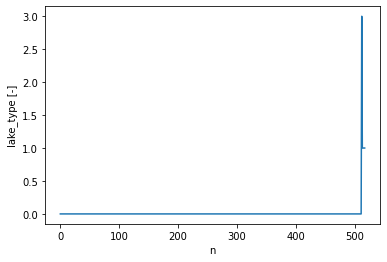

In [5]:
print(ds_slice['HYP_E_emr'][-10:])
print(ds_slice['lake_type'][-10:])
ds_slice['lake_type'].plot()

In [6]:
# pass to the mizuRoute set up
shutil.copy('../data/Network_topology/Network_topology_lake_victoria.nc',
            '../mizuRoute/ancillary_data/Network_topology_lake_victoria.nc')

'../mizuRoute/ancillary_data/Network_topology_lake_victoria.nc'